In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

Base.prepare(engine, reflect = True)


In [6]:
# View all of the classes that automap found
classes = Base.classes
classes_name = Base.classes.keys()
print(classes_name)

['measurement', 'station']


In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Get the column names for the "measurement" table
column_names_m = measurement.__table__.columns.keys()
print(column_names_m)

['id', 'station', 'date', 'prcp', 'tobs']


In [9]:
# Get the column names for the "satation" table
column_names_s = station.__table__.columns.keys()
print(column_names_s)

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
results = session.query(measurement).all()
#for result in results:
    #print(result.id, result.station, result.date, result.prcp, result.tobs)

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)
results_s = session.query(station).all()
for result_s in results_s:
    print(result_s.id, result_s.station, result_s.name, result_s.latitude, result_s.longitude, result_s.elevation )

1 USC00519397 WAIKIKI 717.2, HI US 21.2716 -157.8168 3.0
2 USC00513117 KANEOHE 838.1, HI US 21.4234 -157.8015 14.6
3 USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US 21.5213 -157.8374 7.0
4 USC00517948 PEARL CITY, HI US 21.3934 -157.9751 11.9
5 USC00518838 UPPER WAHIAWA 874.3, HI US 21.4992 -158.0111 306.6
6 USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US 21.33556 -157.71139 19.5
7 USC00519281 WAIHEE 837.5, HI US 21.45167 -157.84888999999998 32.9
8 USC00511918 HONOLULU OBSERVATORY 702.2, HI US 21.3152 -157.9992 0.9
9 USC00516128 MANOA LYON ARBO 785.2, HI US 21.3331 -157.8025 152.4


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
print(most_recent_date)

2017-08-23


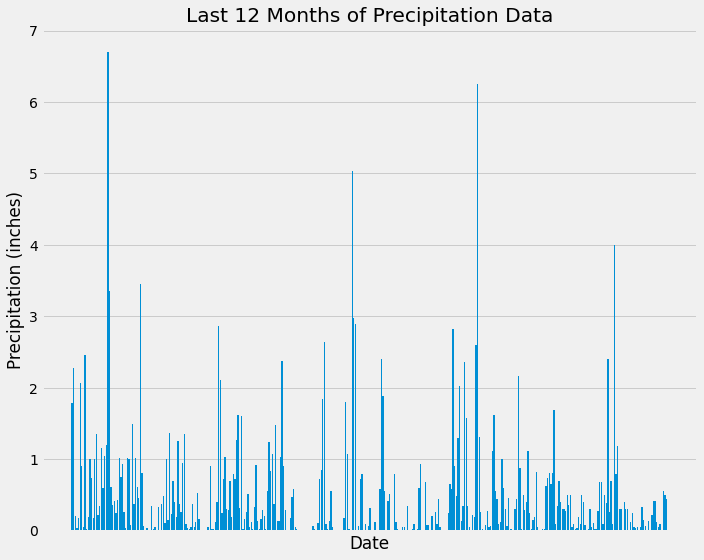

In [13]:

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

import matplotlib.dates as mdates

most_recent_date = session.query(func.max(measurement.date)).scalar()


# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d') 

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).\
          filter(measurement.date >= one_year_ago_str).\
          order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date

df.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(10, 8))
plt.bar(df['Date'], df['Precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation Data')
#plt.xticks(rotation=90)
plt.tight_layout()
# Format x-axis tick labels to display one date per month
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['Precipitation'].describe()
summary_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).all()

# Print the total number of stations
print("Total number of stations:", total_stations)

Total number of stations: [(9,)]


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
from sqlalchemy import desc
active_stations = session.query(measurement.station, func.count(measurement.station)).\
                  group_by(measurement.station).\
                  order_by(desc(func.count(measurement.station))).all()

# List the stations and their counts in descending order.
print("Most active stations:")
for station, count in active_stations:
    print("Station:", station, "Count:", count)

Most active stations:
Station: USC00519281 Count: 2772
Station: USC00519397 Count: 2724
Station: USC00513117 Count: 2709
Station: USC00519523 Count: 2669
Station: USC00516128 Count: 2612
Station: USC00514830 Count: 2202
Station: USC00511918 Count: 1979
Station: USC00517948 Count: 1372
Station: USC00518838 Count: 511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
results = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
          filter(measurement.station == 'USC00519281').all()

# Extract the results
lowest_temp, highest_temp, average_temp = results[0]

# Print the results
print("Lowest Temperature:", lowest_temp)
print("Highest Temperature:", highest_temp)
print("Average Temperature:", average_temp)

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


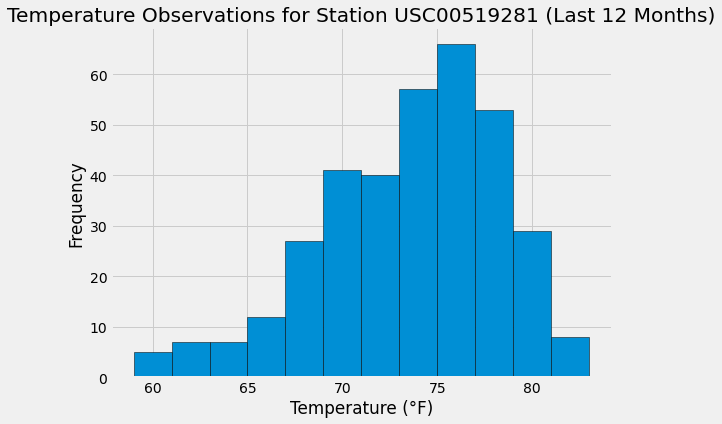

In [18]:
# Using the most active station id, perform a query to retrieve the last 12 months of temperature observation data for the most active station
results = session.query(measurement.date, measurement.tobs).\
          filter(measurement.station == 'USC00519281').\
          filter(measurement.date >= one_year_ago_str).all()

# Save the query results as a Pandas DataFrame and explicitly set column names
df = pd.DataFrame(results, columns=['Date', 'Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(df['Temperature'], bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for Station USC00519281 (Last 12 Months)')
plt.show()

# Close Session

In [19]:
# Close Session
session.close()